In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt, sosfiltfilt
import csv
from matplotlib.font_manager import FontProperties

In [118]:
# Parameters
header_rows = 0
split_num = 1 # also is average number
window_seg_number = 500 # number of segments in each window 2000
sampling_rate = 100e6
zohms = 50

testdata3_time = pd.read_csv('../PDE/data/20250401/时域压缩/RigolDS3.csv', skiprows=header_rows, nrows=250000000, usecols=[0]).squeeze(1).to_numpy()
testdata4_time = pd.read_csv('../PDE/data/20250401/时域压缩/RigolDS4.csv', skiprows=header_rows, nrows=250000000, usecols=[0]).squeeze(1).to_numpy()
testdata5_time = pd.read_csv('../PDE/data/20250401/时域压缩/RigolDS5.csv', skiprows=header_rows, nrows=250000000, usecols=[0]).squeeze(1).to_numpy()

In [119]:
# Signal1
signal1 = testdata3_time[:1000000] #Squ
split_size = len(signal1) // split_num
signal1_split = np.array_split(signal1[:split_size*split_num], split_num)

# Welch's method for signal1
Pxx_avg_seg1 = []
for i in range(split_num):
    f1, Pxx_avg_seg1_ = welch(signal1_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal1_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg1.append(Pxx_avg_seg1_)
Pxx_avg1 = np.mean(Pxx_avg_seg1, axis=0)
Pxx_avg1 = 10 * np.log10(Pxx_avg1 / zohms) + 30

# Signal2
signal2 = testdata4_time
signal2_split = np.array_split(signal2[:split_size*split_num], split_num)
# Welch's method for signal2
Pxx_avg_seg2 = []
for i in range(split_num):
    f2, Pxx_avg_seg2_ = welch(signal2_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal2_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg2.append(Pxx_avg_seg2_)
Pxx_avg2 = np.mean(Pxx_avg_seg2, axis=0)
Pxx_avg2 = 10 * np.log10(Pxx_avg2 / zohms) + 30

# Signal3
signal3 = testdata5_time
signal3_split = np.array_split(signal3[:split_size*split_num], split_num)
# Welch's method for signal3
Pxx_avg_seg3 = []
for i in range(split_num):
    f3, Pxx_avg_seg3_ = welch(signal3_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal3_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg3.append(Pxx_avg_seg3_)
Pxx_avg3 = np.mean(Pxx_avg_seg3, axis=0)
Pxx_avg3 = 10 * np.log10(Pxx_avg3 / zohms) + 30

In [120]:
# Filter design
def butter_lowpass_filter(data, cutoff, fs, order=5, output='sos'):
    if output == 'ba':
        b, a = butter(order, cutoff, btype='low', fs=fs, output='ba')
        y = filtfilt(b, a, data)
    elif output == 'sos':
        sos = butter(order, cutoff, btype='low', fs=fs, output='sos')
        y = sosfiltfilt(sos, data)
    else:
        raise ValueError("output must be 'ba' or 'sos'")
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, output='sos'):
    if output == 'ba':
        b, a = butter(order, [lowcut, highcut], btype='band', fs=fs, output='ba')
        y = filtfilt(b, a, data)
    elif output == 'sos':
        sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
        y = sosfiltfilt(sos, data)
    else:
        raise ValueError("output must be 'ba' or 'sos'")
    return y

filtered_signal = butter_bandpass_filter(signal3, 1e6, 8e6, sampling_rate, order=5) # 1MHz-15MHz


signal4 = filtered_signal #SNL
signal4_split = np.array_split(signal4[:split_size*split_num], split_num)
# Welch's method for signal4
Pxx_avg_seg4 = []
for i in range(split_num):
    f4, Pxx_avg_seg4_ = welch(signal4_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal4_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg4.append(Pxx_avg_seg4_)
Pxx_avg4 = np.mean(Pxx_avg_seg4, axis=0)
Pxx_avg4 = 10 * np.log10(Pxx_avg4 / zohms) + 30



Sampling rate: 100000.0 kHz


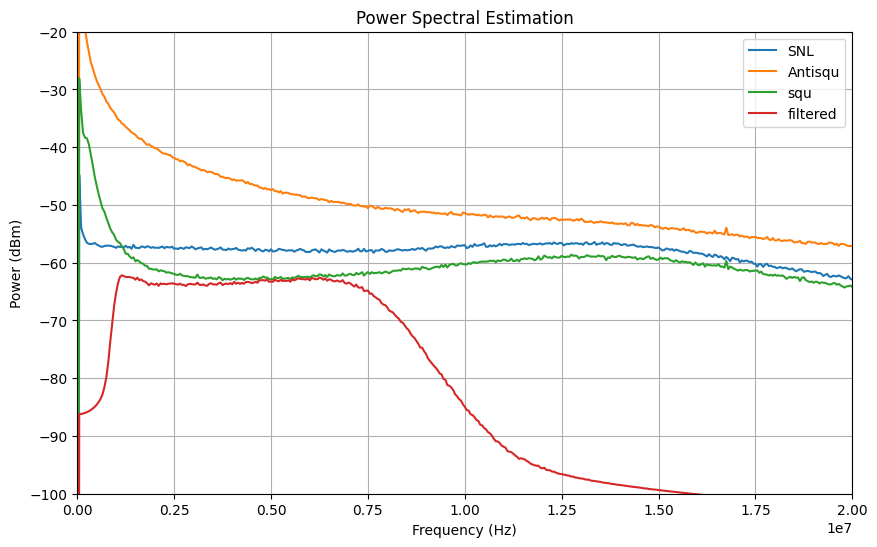

In [121]:
# Plot
print(f'Sampling rate: {sampling_rate/1000} kHz')
yrange = 80
yref = -60
plt.figure(figsize=(10, 6))
plt.plot(f1, Pxx_avg1, label='SNL')
plt.plot(f2, Pxx_avg2, label='Antisqu')
plt.plot(f3, Pxx_avg3, label='squ')
plt.plot(f4, Pxx_avg4, label='filtered')
plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,20e6)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()
